In [1]:
%run utils.py

In [2]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [15]:
import awkward as ak
from physlite_experiments.physlite_events import Factory
from physlite_experiments.analysis_example import get_obj_sel
import fsspec
import pyarrow.parquet as pq
import requests
import io
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import gc

setup_rucio_and_proxy(upload.data[-1])
from rucio.client import Client
rucio_client = Client()

In [4]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp.00338183.r10258_p3399_p4309_tid22958105_00_output.parquet"))

In [5]:
url = get_signed_url(rucio_client, "user.nihartma", files[0]["name"])

In [6]:
%%time
with fsspec.open(url, cache_type="none") as f:
    events = Factory.from_parquet(f, row_groups=0).events

CPU times: user 181 ms, sys: 18.1 ms, total: 199 ms
Wall time: 458 ms


In [8]:
events.Electrons.trackParticles

<xAODTrackParticleArray [[], [], [], [], ... [], []] type='44235 * var * var * x...'>

In [9]:
%%time
events_decorated = get_obj_sel(events)

/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:160: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


CPU times: user 3.67 s, sys: 991 ms, total: 4.66 s
Wall time: 6.53 s


In [10]:
len(events)

44235

In [12]:
def run_analysis(f, **kwargs):
    events = Factory.from_parquet(f, **kwargs).events
    events_decorated = get_obj_sel(events)
    return events_decorated

In [13]:
%%time
data = requests.get(url).content
res = run_analysis(io.BytesIO(data))

CPU times: user 4.21 s, sys: 1.39 s, total: 5.61 s
Wall time: 5.74 s


In [14]:
%%time
with fsspec.open(url, cache_type="none") as f:
    res = run_analysis(f)

CPU times: user 3.75 s, sys: 831 ms, total: 4.58 s
Wall time: 6.11 s


In [18]:
def get_leptons(url):
    with fsspec.open(url, cache_type="none") as f:
        pqf = pq.ParquetFile(f)
        leptons = []
        for i in range(pqf.num_row_groups):
            events_decorated = run_analysis(f, row_groups=i)
            events_decorated["Muons", "m"] = 105.6583715
            leptons.append(
                ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
            )
        leptons = ak.concatenate(leptons)
        leptons = leptons[["pt", "eta", "phi", "m", "passOR", "baseline", "signal"]]
        leptons = ak.copy(ak.from_arrow(ak.to_arrow(leptons)))
        del events_decorated
        gc.collect()
    return ak.to_arrow(leptons)

In [20]:
%%time
res = get_leptons(url)

CPU times: user 3.88 s, sys: 751 ms, total: 4.63 s
Wall time: 6.3 s


In [23]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster(
    worker_cores=1,
    worker_memory=3.5,
    image="eu.gcr.io/gke-dev-311213/dask-gateway-physlite:20210622"
)
cluster

In [49]:
#cluster.shutdown()

In [25]:
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| numpy   | 1.19.4        | 1.19.2        | 1.19.2        |
| python  | 3.8.6.final.0 | 3.8.3.final.0 | 3.8.3.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [38]:
client.restart()

Client Scheduler: gateway://traefik-dhub-dask-gateway.default:80/default.bd5945b104964835a76302e5e57d5118 Dashboard: /services/dask-gateway/clusters/default.bd5945b104964835a76302e5e57d5118/status,Cluster Workers: 93 Cores: 93 Memory: 349.50 GB


In [39]:
len(files)

974

In [40]:
import dask
from dask import delayed

In [42]:
tasks = []
for file in files:
    d_url = delayed(get_signed_url_worker)(upload.data[-1], file["scope"], file["name"])
    d_leptons = delayed(get_leptons)(d_url)
    tasks.append(d_leptons)

In [31]:
#tasks = dask.persist(*tasks)

In [44]:
from dask.distributed import performance_report, wait
with performance_report(filename="dask-report-1percent-parquet.html"):
    tasks = dask.persist(*tasks)
    wait(tasks)

In [45]:
def get_mass(leptons, selection="all"):
    leptons = ak.from_arrow(leptons)
    leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
    if selection == "all":
        l1, l2 = ak.unzip(ak.combinations(leptons, 2))
    elif selection == "signal":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
    elif selection == "baseline":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
    l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
    m = (l1 + l2).mass
    m = ak.flatten(m, axis=None)
    m = ak.to_numpy(m)
    return m

In [46]:
(m_list_all,) = dask.compute([delayed(partial(get_mass, selection="all"))(i) for i in tasks])

In [47]:
GeV = 1000.

<ipython-input-48-c7c44ec3c1eb>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e7)


(166.09899597059956, 10000000.0)

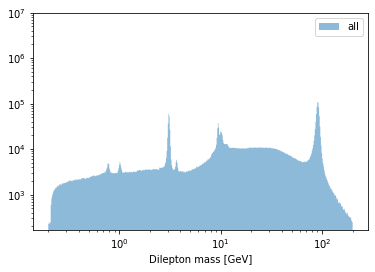

In [48]:
opts = dict(
    bins=np.geomspace(0.2, 200, 500),
    histtype="stepfilled", alpha=0.5
)
plt.hist(np.concatenate(m_list_all) / GeV, label="all", **opts);
#plt.hist(np.concatenate(m_list_baseline) / GeV, label="after baseline selection", **opts);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Dilepton mass [GeV]")
plt.legend()
plt.ylim(0, 1e7)